import packages

In [1]:
import scipy.optimize as opt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dataset and plotting

In [2]:
def lorenztian(x, A, sigma, mu):
    return A/np.pi * (sigma/((x-mu)**2+sigma**2))

def double_lorenztian(x, a1, s1, m1, a2, s2, m2, y0):
    return lorenztian(x, a1,s1,m1)+lorenztian(x,a2,s2,m2)+y0

In [3]:
file_path = f"./ruby 100K.asc"
df_results = pd.read_csv(file_path,sep="\t",names=['WaveLength', 'Results'],skiprows=40,usecols=range(2),header=None)
display(df_results)

,WaveLength,Results
0,662.72107,484
1,662.77649,487
2,662.83191,487
3,662.88727,485
4,662.94269,487
...,...,...
1005,716.80798,500
1006,716.85999,502
1007,716.91205,499
1008,716.96411,500


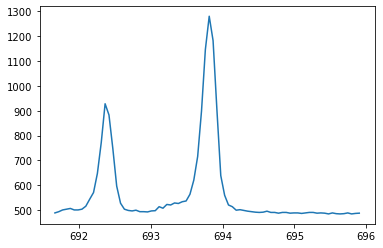

In [4]:
x = df_results.WaveLength.values
y = df_results.Results.values

max_idx = np.argmax(y)
view_range = 40
x = x[max_idx-view_range : max_idx+view_range].copy()
y = y[max_idx-view_range : max_idx+view_range].copy()
plt.plot(x,y)

In [5]:
p0=[900*np.pi*0.05,0,693.5,1300*np.pi*0.05,0,692.5,0]
popt, pcov = opt.curve_fit(double_lorenztian, x, y, p0=p0, 
                           method="trf",
                           ftol=1e-15, xtol = 1e-15, gtol = 1e-15,
                           max_nfev=20000, 
                           x_scale = [1, 0.0001, 0.001, 1, 0.0001, 0.001,1])

In [6]:
def adjr_squared(y, y_pred,p):
    residuals = y - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    n = len(y)
    r_squared = 1 - ((ss_res/(n-p)) / (ss_tot/(n-1)))

    return r_squared

In [7]:
r_square = adjr_squared(y, double_lorenztian(x, *popt), 1)

plot fitted curve and data with r-squared value

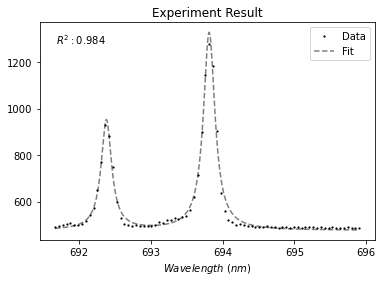

In [8]:
plt.plot(x,y, 'ko', markersize=1.2, label="Data")
xfit = np.linspace(np.min(x), np.max(x), 500)
plt.plot(xfit, double_lorenztian(xfit, *popt), 'k--', alpha=0.5,label="Fit")
plt.title(f"Experiment Result")
plt.xlabel(r"$Wavelength \ (nm)$")
plt.text(0.05, 0.90, f'$R^2 : {r_square:.3f}$', transform=plt.gca().transAxes)

plt.legend()

calculate error of regression parameters

In [9]:
err = np.sqrt(np.diag(pcov))
print(popt)
print(err)

[2.59762838e+02 9.72039048e-02 6.93812922e+02 1.31543424e+02
 8.84284282e-02 6.92381696e+02 4.76160349e+02]
[6.17770560e+00 2.98453365e-03 1.96521853e-03 5.79808959e+00
 5.13756371e-03 3.33459113e-03 3.05002242e+00]


example   
H0 : two peaks has same FWHM. (FWHM1 = FWHM2 )
H1 : not H0 (FWHM1 > FWHM2 )  
one-tailed test

In [10]:
from uncertainties import ufloat
import scipy.stats as stats

First Peak FWHM : 0.0486+/-0.0015 nm
Second Peak FWHM : 0.0442+/-0.0026 nm
statistic : 1.4769678689855734


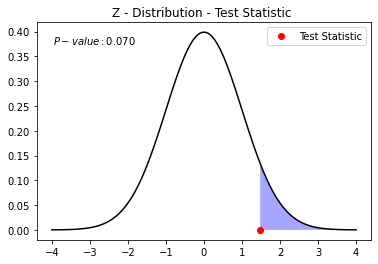

In [11]:
x1 = ufloat(popt[1], err[1])
x2 = ufloat(popt[4], err[4])
print(f"First Peak FWHM : {x1/2} nm")
print(f"Second Peak FWHM : {x2/2} nm")

statistic = (x1.n-x2.n)/np.sqrt(x1.s**2+x2.s**2)
print(f"statistic : {statistic}")
cdf = stats.norm(0,1).cdf(statistic)

z = np.linspace(-4, 4, 100)
plt.plot(z, stats.norm.pdf(z), "k")
plt.plot(statistic, 0, "ro",label=f"Test Statistic")
z_exceed= np.linspace(statistic, 4, 100)
plt.fill_between(z_exceed, stats.norm.pdf(z_exceed), facecolor='blue', alpha=0.35)
plt.title("Z - Distribution - Test Statistic ")
p_val = 1-cdf
plt.text(0.05, 0.90, f'$P-value : {p_val:.3f}$', transform=plt.gca().transAxes)
plt.legend()


with 0.05 significance level, p-val = 0.07, H0 no not rejected  
∴ Two peaks has same FWHM

More : two tailed Test

First Peak FWHM : 0.0486+/-0.0015 nm
Second Peak FWHM : 0.0442+/-0.0026 nm
statistic : 1.4769678689855734


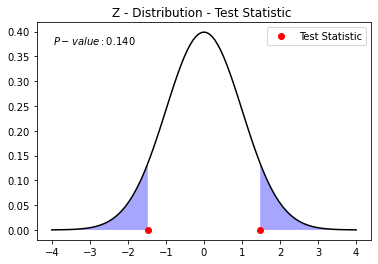

In [12]:
x1 = ufloat(popt[1], err[1])
x2 = ufloat(popt[4], err[4])
print(f"First Peak FWHM : {x1/2} nm")
print(f"Second Peak FWHM : {x2/2} nm")

statistic = (x1.n-x2.n)/np.sqrt(x1.s**2+x2.s**2)
print(f"statistic : {statistic}")
cdf = stats.norm(0,1).cdf(statistic)

z = np.linspace(-4, 4, 100)
plt.plot(z, stats.norm.pdf(z), "k")

plt.plot(statistic, 0, "ro",label=f"Test Statistic")
plt.plot(-statistic, 0, "ro")

z_exceed= np.linspace(statistic, 4, 100)
z_exceed_left= np.linspace(-4, -statistic, 100)

plt.fill_between(z_exceed, stats.norm.pdf(z_exceed), facecolor='blue', alpha=0.35)
plt.fill_between(z_exceed_left, stats.norm.pdf(z_exceed_left), facecolor='blue', alpha=0.35)


plt.title("Z - Distribution - Test Statistic ")
p_val = 1-cdf
p_val = 2*p_val
plt.text(0.05, 0.90, f'$P-value : {p_val:.3f}$', transform=plt.gca().transAxes)
plt.legend()
